## Question

In [2]:
import os
import tarfile
import urllib.request

# Download the dataset
DATASET_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
data_dir = './data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the dataset
dataset_path = os.path.join(data_dir, 'speech_commands_v0.02.tar.gz')
urllib.request.urlretrieve(DATASET_URL, dataset_path)

# Extract the dataset
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

print("Dataset downloaded and extracted.")


Dataset downloaded and extracted.


In [3]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
from IPython import display

AUTOTUNE = tf.data.AUTOTUNE


In [4]:
data_dir = pathlib.Path("./data")

# Get the labels (the subdirectories in the dataset)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']  # Exclude the README.md file
print('Commands:', commands)


Commands: ['speech_commands_v0.02.tar.gz' 'no' 'right' 'left' 'zero' 'seven'
 'forward' 'six' '_background_noise_' 'two' 'wow' 'happy' 'four' 'one'
 'down' 'sheila' 'learn' 'go' 'bed' 'validation_list.txt' 'yes' 'on'
 'house' 'bird' '.DS_Store' 'nine' 'stop' 'three' 'up' 'dog' 'backward'
 'testing_list.txt' 'tree' 'LICENSE' 'five' 'marvin' 'off' 'eight' 'cat'
 'follow' 'visual']


In [5]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    label = get_label(file_path)
    return waveform, label

# Load file paths
files = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
files = tf.random.shuffle(files)

print("Number of audio files:", len(files))

# Create a dataset from the file paths
files_ds = tf.data.Dataset.from_tensor_slices(files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


Number of audio files: 105835


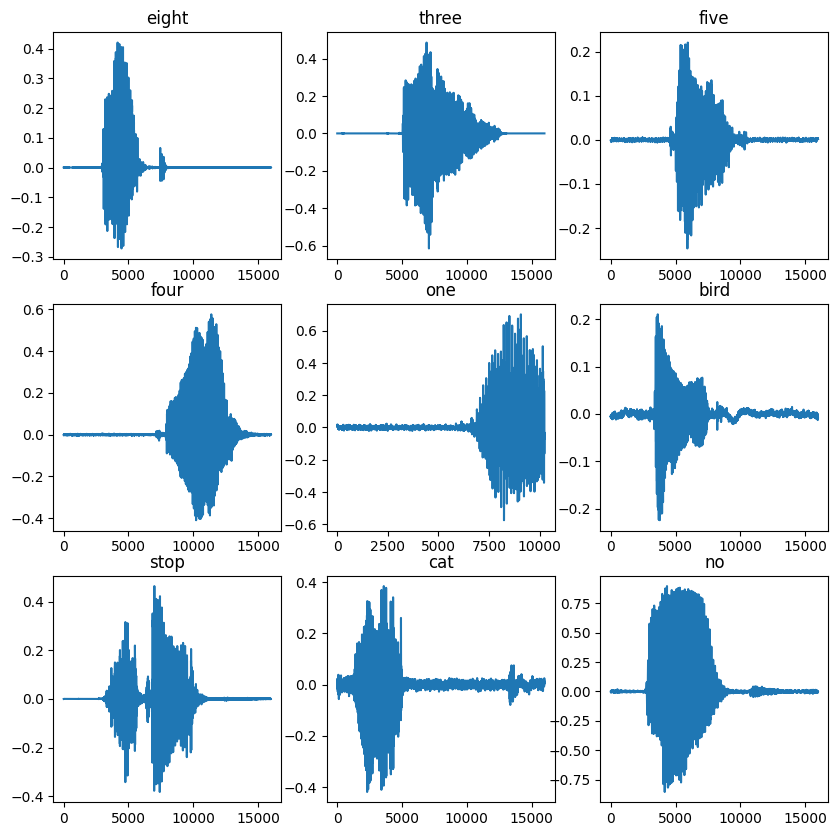

In [6]:
rows = 3
cols = 3
n = rows * cols
waveforms, labels = zip(*[(waveform.numpy(), label.numpy().decode('utf-8')) for waveform, label in waveform_ds.take(n)])

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (waveform, label) in enumerate(zip(waveforms, labels)):
    r = i // cols
    c = i % cols
    axes[r][c].plot(waveform)
    axes[r][c].set_title(label)

plt.show()


In [7]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate the waveform with zero padding
    waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Add an extra channel dimension (for mono audio)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    return spectrogram


def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


In [8]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

train_files = files[:int(len(files) * 0.8)]
val_files = files[int(len(files) * 0.8):]

train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [9]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(commands))
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  

In [10]:
EPOCHS = 1

# Add a call to .cache() and .prefetch() to the training and validation datasets

history = model.fit(train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE), validation_data=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE), epochs=EPOCHS)

 379/1323 [=======>......................] - ETA: 1:28 - loss: 1.9130 - accuracy: 0.4858

InvalidArgumentError: Graph execution error:

Detected at node zeros defined at (most recent call last):
<stack traces unavailable>
Detected at node zeros defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Dimension -944000 must be >= 0
	 [[{{node zeros}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_7]]
  (1) INVALID_ARGUMENT:  Dimension -944000 must be >= 0
	 [[{{node zeros}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1927]